In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/parsmap/ParsMap.xlsx


# Sources
- https://tuanatran.medium.com/fine-tuning-large-language-model-with-hugging-face-pytorch-adce80dce2ad
- https://www.kaggle.com/code/shayanbemanian/persian-informal-to-formal-transformation

# W&B first of all:)

In [2]:
import warnings
warnings.filterwarnings('ignore') 
# ------------------------
!pip uninstall -y --quiet wandb
!pip install --quiet wandb==0.17.5 
# ------------------------
import wandb
!wandb offline
!wandb disabled
# ------------------------
import os
os.environ["WANDB_DISABLED"] = "true"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 46.6 MB/s eta 0:00:0000:0100:01
W&B offline. Running your script from this directory will only write metadata locally. Use wandb disabled to completely turn off W&B.
W&B disabled.


# Install libraries

In [3]:
!pip install --quiet --upgrade datasets transformers evaluate sentencepiece accelerate 
!pip install --quiet dadmatools[full]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 10.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 93.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.7/374.7 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.5/561.5 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:0

In [4]:
!pip install -U peft accelerate
!pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.9/503.9 kB 8.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: peft
    Found existing installation: peft 0.15.2
    Uninstalling peft-0.15.2:
      Successfully uninstalled peft-0.15.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 29.0 MB/s eta 0:00:00:00:0100:01


# Libraries

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from dadmatools.normalizer import Normalizer

import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler, random_split
from torch.optim import AdamW

from transformers import AutoTokenizer, AutoConfig, GPT2LMHeadModel, GPT2Config, get_linear_schedule_with_warmup

import seaborn as sns
import matplotlib.pyplot as plt

import re
import random
import time
import datetime
import os

from huggingface_hub import login

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from hazm import *


2025-08-13 06:51:42.343691: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755067902.551285      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755067902.612560      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
tqdm.pandas()

# Read input data

In [7]:
df_parsmap = pd.read_excel("/kaggle/input/parsmap/ParsMap.xlsx")
df_parsmap.head()

,inFormalForm,formalForm,formalWords,inFormalWords
0,من دوس دارم برم خونه درس بخونم.,من دوست دارم که به خانه بروم تا درس بخوانم.,من/دوست/دارم/بروم/خانه/درس/بخوانم,من/دوس/دارم/برم/خونه/درس/بخونم
1,میتونی منو ببری خونمون یکم نون وردارم؟,می‌توانی من را به خانه‌مان ببری تا کمی نان برد...,می‌توانی/من را/ببری/خانه‌مان/کمی/نان/بردارم,میتونی/منو/ببری/خونمون/یکم/نون/وردارم
2,رفتم درمونگاه واسه بچم دوا بگیرم، یهو بارون گرفت,به درمانگاه رفتم تا برای بچه‌ام دوا بگیرم که ی...,رفتم/درمانگاه/برای/بچه‌ام/دوا/بگیرم/یکهو/باران...,رفتم/درمونگاه/واسه/بچم/دوا/بگیرم/یهو/بارون/گرفت
3,اون که خدا شاهده مث دیوونه هاس,خدا شاهد است که او مثل دیوانه‌ها است.,شاهد است/او/که/خدا/مثل/دیوانه‌ها است,شاهده/اون/که/خدا/مث/دیوونه هاس
4,یه سری آدما هستن که هر قدر خوبی کنی اصلن انگار...,یک سری آدم‌ها هستند که هر قدر هم خوبی کنی، اصل...,یک/سری/آدم‌ها/هستند/که/هر/قدر/خوبی/کنی/اصلاً/ا...,یه/سری/آدما/هستن/که/هر/قدر/خوبی/کنی/اصلن/انگار...


In [8]:
normalizer = Normalizer(
    full_cleaning=False,
    unify_chars=True,
    refine_punc_spacing=True,
    remove_extra_space=True,
    remove_puncs=False,
    remove_html=True,
    remove_stop_word=False,
    replace_email_with="<EMAIL>",
    replace_number_with=None,
    replace_url_with="",
    replace_mobile_number_with=None,
    replace_emoji_with=None,
    replace_home_number_with=None
)

text = 'من دوس دارم برم خونه درس بخونم    .'
print(normalizer.normalize(text))

من دوس دارم برم خونه درس بخونم.


In [9]:
def normalize_text(text):
    if pd.isna(text):
        return text
    return normalizer.normalize(str(text))

In [10]:
df_parsmap['formalForm'] = df_parsmap['formalForm'].progress_apply(normalize_text)
df_parsmap['inFormalForm'] = df_parsmap['inFormalForm'].progress_apply(normalize_text)

df_parsmap.head()

100%|██████████| 50014/50014 [00:06<00:00, 7756.09it/s]


,inFormalForm,formalForm,formalWords,inFormalWords
0,من دوس دارم برم خونه درس بخونم.,من دوست دارم که به خانه بروم تا درس بخوانم.,من/دوست/دارم/بروم/خانه/درس/بخوانم,من/دوس/دارم/برم/خونه/درس/بخونم
1,میتونی منو ببری خونمون یکم نون وردارم؟,می‌توانی من را به خانه‌مان ببری تا کمی نان برد...,می‌توانی/من را/ببری/خانه‌مان/کمی/نان/بردارم,میتونی/منو/ببری/خونمون/یکم/نون/وردارم
2,رفتم درمونگاه واسه بچم دوا بگیرم، یهو بارون گرفت,به درمانگاه رفتم تا برای بچه‌ام دوا بگیرم که ی...,رفتم/درمانگاه/برای/بچه‌ام/دوا/بگیرم/یکهو/باران...,رفتم/درمونگاه/واسه/بچم/دوا/بگیرم/یهو/بارون/گرفت
3,اون که خدا شاهده مث دیوونه هاس,خدا شاهد است که او مثل دیوانه‌ها است.,شاهد است/او/که/خدا/مثل/دیوانه‌ها است,شاهده/اون/که/خدا/مث/دیوونه هاس
4,یه سری آدما هستن که هر قدر خوبی کنی اصلن انگار...,یک سری آدم‌ها هستند که هر قدر هم خوبی کنی، اصل...,یک/سری/آدم‌ها/هستند/که/هر/قدر/خوبی/کنی/اصلاً/ا...,یه/سری/آدما/هستن/که/هر/قدر/خوبی/کنی/اصلن/انگار...


In [11]:
df_parsmap = df_parsmap.dropna(subset=["inFormalForm", "formalForm"])

In [12]:
df_parsmap["text"] = "<|startoftext|>" + "[Informal]" + df_parsmap["inFormalForm"].apply(lambda t: t.replace("    ", "<sep>").replace("\t", "<sep>")) + "[Formal]" + df_parsmap["formalForm"].apply(lambda t: t.replace("    ", "<sep>").replace("\t", "<sep>")) + "<|endoftext|>"

df_parsmap.head()

,inFormalForm,formalForm,formalWords,inFormalWords,text
0,من دوس دارم برم خونه درس بخونم.,من دوست دارم که به خانه بروم تا درس بخوانم.,من/دوست/دارم/بروم/خانه/درس/بخوانم,من/دوس/دارم/برم/خونه/درس/بخونم,<|startoftext|>[Informal]من دوس دارم برم خونه ...
1,میتونی منو ببری خونمون یکم نون وردارم؟,می‌توانی من را به خانه‌مان ببری تا کمی نان برد...,می‌توانی/من را/ببری/خانه‌مان/کمی/نان/بردارم,میتونی/منو/ببری/خونمون/یکم/نون/وردارم,<|startoftext|>[Informal]میتونی منو ببری خونمو...
2,رفتم درمونگاه واسه بچم دوا بگیرم، یهو بارون گرفت,به درمانگاه رفتم تا برای بچه‌ام دوا بگیرم که ی...,رفتم/درمانگاه/برای/بچه‌ام/دوا/بگیرم/یکهو/باران...,رفتم/درمونگاه/واسه/بچم/دوا/بگیرم/یهو/بارون/گرفت,<|startoftext|>[Informal]رفتم درمونگاه واسه بچ...
3,اون که خدا شاهده مث دیوونه هاس,خدا شاهد است که او مثل دیوانه‌ها است.,شاهد است/او/که/خدا/مثل/دیوانه‌ها است,شاهده/اون/که/خدا/مث/دیوونه هاس,<|startoftext|>[Informal]اون که خدا شاهده مث د...
4,یه سری آدما هستن که هر قدر خوبی کنی اصلن انگار...,یک سری آدم‌ها هستند که هر قدر هم خوبی کنی، اصل...,یک/سری/آدم‌ها/هستند/که/هر/قدر/خوبی/کنی/اصلاً/ا...,یه/سری/آدما/هستن/که/هر/قدر/خوبی/کنی/اصلن/انگار...,<|startoftext|>[Informal]یه سری آدما هستن که ه...


In [14]:
df_parsmap['text'][34]

'<|startoftext|>[Informal]از همه نظر عالیه ولی بزرگترین ایرادش اینه که صدای مکالمه در کمترین میزان ولوم هم انگار روی پخش کنه[Formal]از همه نظر عالی است؛ ولی بزرگ\u200cترین ایرادش این است که صدای مکالمه در کمترین میزان ولوم هم انگار روی پخش\u200cکن است.<|endoftext|>'

In [13]:
model_name_or_path = "HooshvareLab/gpt2-fa" # ViraIntelligentDataMining/PersianLLaMA-13B, ViraIntelligentDataMining/PersianLLaMA-13B-Instruct
                                            # universitytehran/SmolLM-135M-10M-word, universitytehran/PersianMind-v1.0
                                            # MaralGPT/Maral-7B-alpha-1

tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path,
    bos_token='<s>',
    eos_token='</s>',
    pad_token='<pad>',
    unk_token='<unk>'
)
tokenizer.add_special_tokens({
    "bos_token": '</s>',
    "eos_token": '</s>',
    "pad_token": '<pad>',
    "unk_token": '<unk>'
})

config = AutoConfig.from_pretrained(
    model_name_or_path,
    bos_token_id=tokenizer("<s>")["input_ids"][0],
    eos_token_id=tokenizer("</s>")["input_ids"][0],
    pad_token_id=tokenizer("<pad>")["input_ids"][0],
    unk_token_id=tokenizer("<unk>")["input_ids"][0],
)

# tokenizer.save_pretrained("/kaggle/working/gpt2/")
# config.save_pretrained("/kaggle/working/gpt2/")

# !wget "https://huggingface.co/HooshvareLab/gpt2-fa/resolve/main/pytorch_model.bin" -P /kaggle/working/gpt2/
# !wget "https://huggingface.co/HooshvareLab/gpt2-fa/resolve/main/tokenizer.json" -P /kaggle/working/gpt2/

tokenizer_config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/808 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/14.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/104 [00:00<?, ?B/s]

In [16]:
# tokenizer = AutoTokenizer.from_pretrained(
#     "/kaggle/working/gpt2",
#     bos_token='<s>',
#     eos_token='</s>',
#     pad_token='<pad>'
# )

print(tokenizer.encode("سلام بر شما"))
print(tokenizer.encode("<s>"))
print(tokenizer.encode("</s>"))
print(tokenizer.encode("<pad>"))
print(tokenizer.encode("<|startoftext|>"))
print(tokenizer.encode("<|endoftext|>"))
print(tokenizer.encode("<sep>"))

[8906, 327, 512]
[0]
[2]
[1]
[6]
[5]
[9]


In [14]:
texts = df_parsmap["text"].values.tolist()

print(len(texts))

50013


In [15]:
max_seq = 256

In [16]:
torch.manual_seed(42)

class MTGDataset(Dataset):
    def __init__(self, txt_list, tokenizer, max_length=1024):
        self.tokenizer = tokenizer  # the gpt2 tokenizer we instantiated
        self.input_ids = []
        self.attn_masks = []

        for txt in txt_list:
            """
            This loop will iterate through each entry in the flavour text corpus.
            For each bit of text it will prepend it with the start of text token,
            then append the end of text token and pad to the maximum length with the
            pad token.
            """

            encodings_dict = tokenizer('<s>' + txt + '</s>',
                                       truncation=True,
                                       max_length=max_length,
                                       padding="max_length")

            """
            Each iteration then appends either the encoded tensor to a list,
            or the attention mask for that encoding to a list. The attention mask is
            a binary list of 1's or 0's which determine whether the langauge model
            should take that token into consideration or not.
            """
            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx]

In [17]:
dataset = MTGDataset(texts, tokenizer, max_length=max_seq)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

f'There are {len(train_dataset)} samples for training, and {len(val_dataset)} samples for validation testing'

'There are 45011 samples for training, and 5002 samples for validation testing'

In [21]:
print(train_dataset[0][0][:100])
print(tokenizer.decode(train_dataset[0][0][:100]))

tensor([    0,     6,    69,  9081,  9942,  1353,    71,  8878,  1811,   564,
          547,   323, 12595,   662,    24,   747,  1994,   271,  1811,   814,
         4225,    69,    48, 33621,    71,  8878,   298,   564,   547,   323,
          326,   285,  7610,   662,    24,   747,   298,   814,  4225,  1994,
          590,    24,     5,     2,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1])
<s><|startoftext|>[Informal]البته توی کشور ما که اینجوری نیست. همه آزادن توی فیلم ساختن[Formal]البته در کشور ما که این‌جوری نیست. همه در فیلم ساختن آزاد هستند.<|endoftext|></s><pad><pad><pad><pad><pad><pad><pad><pad><pa

In [18]:
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=8
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=8
)

In [24]:
# configuration = GPT2Config.from_pretrained(model_name_or_path, output_hidden_states=False)

# # Create the instance of the model and set the token size embedding length
# model = GPT2LMHeadModel.from_pretrained(model_name_or_path, config=configuration)
# # important before PEFT
# model.resize_token_embeddings(len(tokenizer))

# # Tell pytorch to run this model on the GPU.
# device = torch.device("cuda")
# model.cuda()

# # This step is optional but will enable reproducible runs.
# seed_val = 42

# random.seed(seed_val)
# np.random.seed(seed_val)
# torch.manual_seed(seed_val)
# if torch.cuda.is_available():
#     print("------------------------ CUDA IS AVAILABLE -------------------------")
#     torch.cuda.manual_seed_all(seed_val)

pytorch_model.bin:   0%|          | 0.00/485M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/485M [00:00<?, ?B/s]

------------------------ CUDA IS AVAILABLE -------------------------


In [20]:
# QLoRA
from transformers import BitsAndBytesConfig
from peft import prepare_model_for_kbit_training


quant_config = BitsAndBytesConfig(load_in_8bit=True)  
configuration = GPT2Config.from_pretrained(model_name_or_path, output_hidden_states=False)

model = GPT2LMHeadModel.from_pretrained(
    model_name_or_path,
    config=configuration,
    quantization_config=quant_config,
    device_map="auto"
)

model.resize_token_embeddings(len(tokenizer))

model = prepare_model_for_kbit_training(model)


# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
# model.cuda()

# This step is optional but will enable reproducible runs.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
    print("------------------------ CUDA IS AVAILABLE -------------------------")
    torch.cuda.manual_seed_all(seed_val)

------------------------ CUDA IS AVAILABLE -------------------------


In [22]:
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model


# LoRA config
lora_config = LoraConfig(
    r=16,  # rank
    lora_alpha=32,
    target_modules=["c_attn", "c_proj"],  # GPT-2 attention projection layers
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

# Apply LoRA
model = get_peft_model(model, lora_config)

In [23]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_params = 0
    for _, param in model.named_parameters():
        all_params += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"Trainable params: {trainable_params} / {all_params} "
          f"({100 * trainable_params / all_params:.2f}%)")

print_trainable_parameters(model)

Trainable params: 1622016 / 119721216 (1.35%)


In [31]:
epochs = 2
warmup_steps = 50
sample_every = 200

In [32]:
# AdamW is a class from the huggingface library, it is the optimizer we will be using, and we will only be instantiating it with the default parameters.
optimizer = AdamW(
    model.parameters(),
    lr=2e-4,
    eps=1e-8
)

In [33]:
# Total training steps is the number of data points, times the number of epochs.
# Essentially, epochs are training cycles, how many times each point will be seen by the model.

total_steps = len(train_dataloader) * epochs
print(total_steps)

# We can set a variable learning rate which will help scan larger areas of the
# problem space at higher LR earlier, then fine tune to find the exact model minima
# at lower LR later in training.

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps)

11254


In [34]:
sample_informal = df_parsmap['inFormalForm'][np.random.randint(0, len(df_parsmap['inFormalForm']))]
sample_input = f"<s><|startoftext|>[Informal]{sample_informal}[Formal]"
print(sample_input)
sample_input_ids = torch.tensor(tokenizer([sample_input])["input_ids"])
sample_input_ids = sample_input_ids.to(device)

sample_outputs = model.generate(
    input_ids=sample_input_ids,
    # bos_token_id=random.randint(1, len(tokenizer.get_vocab())),
    do_sample=True,
    top_k=50,
    max_length=50,
    top_p=0.95,
    num_return_sequences=1
)
for i, sample_output in enumerate(sample_outputs):
    gen_sample_output = tokenizer.decode(sample_output, skip_special_tokens=False)
    gen_sample_output = gen_sample_output.replace("<|startoftext|>", "")
    gen_sample_output = gen_sample_output.replace("[Informal]", "\n")
    gen_sample_output = gen_sample_output.replace("[Formal]", "\n")
    gen_sample_output = gen_sample_output.replace("<|endoftext|>", "")
    gen_sample_output = gen_sample_output.replace("<s>", "")
    gen_sample_output = gen_sample_output.replace("</s>", "")
    gen_sample_output = gen_sample_output.replace("<sep>", "\n")

    print(f'Example output: {gen_sample_output}')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.


<s><|startoftext|>[Informal]نتیجشم یه گام به عقبه.[Formal]
Example output: 
نتیجشم یه گام به عقبه.
کسی هستند دارند مثل مثل،،، و و و آن آن آن همه آنها ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌


In [35]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [36]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in tqdm(range(0, epochs), position=0):

    print(f'Beginning epoch {epoch_i + 1} of {epochs}')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), position=0):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, labels=b_labels, attention_mask=b_masks, token_type_ids=None)

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every 100 batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print()
            print(f'Batch {step} of {len(train_dataloader)}. Loss:{batch_loss}. Time:{elapsed}')

            model.eval()

            # sample_poet = poets[np.random.randint(0, len(poets))]
            # sample_input = f"<s>{sample_poet}<|startoftext|>"
            sample_informal = df_parsmap['inFormalForm'][np.random.randint(0, len(df_parsmap['inFormalForm']))]
            sample_input = f"<s><|startoftext|>[Informal]{sample_informal}[Formal]"
            sample_input_ids = torch.tensor(tokenizer([sample_input])["input_ids"])
            sample_input_ids = sample_input_ids.to(device)

            sample_outputs = model.generate(
                input_ids=sample_input_ids,
                # bos_token_id=random.randint(1, len(tokenizer.get_vocab())),
                do_sample=True,
                top_k=50,
                max_length=50,
                top_p=0.95,
                num_return_sequences=1
            )
            for i, sample_output in enumerate(sample_outputs):
                gen_sample_output = tokenizer.decode(sample_output, skip_special_tokens=False)
                gen_sample_output = gen_sample_output.replace("<|startoftext|>", "")
                gen_sample_output = gen_sample_output.replace("[Informal]", "\n")
                gen_sample_output = gen_sample_output.replace("[Formal]", "\n")
                gen_sample_output = gen_sample_output.replace("<|endoftext|>", "")
                gen_sample_output = gen_sample_output.replace("<s>", "")
                gen_sample_output = gen_sample_output.replace("</s>", "")
                gen_sample_output = gen_sample_output.replace("<sep>", "\n")

                print(f'Example output: {gen_sample_output}')

            model.train()

        loss.backward()
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print()
    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')
    print()

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in tqdm(validation_dataloader, total=len(validation_dataloader), position=0):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs = model(b_input_ids, attention_mask=b_masks, labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print()
    print(f'Validation loss: {avg_val_loss}. Validation Time: {validation_time}')
    print()

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print(f'Total training took {format_time(time.time()-total_t0)}')

  0%|          | 0/2 [00:00<?, ?it/s]

Beginning epoch 1 of 2


  4%|▎         | 200/5627 [01:43<46:16,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 200 of 5627. Loss:0.44944489002227783. Time:0:01:43
Example output: 
یه جورایی شبیه به سیستم قرقره ایه
یکی از بهترین جاهایی که می‌شود آن را شبیه‌سازی کرد، ایستگاه مترو است که در آن باید آن را شبیه‌سازی کرد.


  7%|▋         | 400/5627 [03:27<44:42,  1.95it/s]  The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 400 of 5627. Loss:0.4388372600078583. Time:0:03:27
Example output: 
فقط مشکل اینه من تا به اون چیزی که تو سرمه نرسم آروم نمیشم.
فقط مشکل من است که تا به آن چیزی که در سرمه‌اش است آرام نروم.


 11%|█         | 600/5627 [05:10<42:51,  1.95it/s]  The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 600 of 5627. Loss:0.38751018047332764. Time:0:05:11
Example output: 
بچه که بودم می دیدم که بچه ها به قطار سنگ می زنن بعدها فهمیدم هر کسی که در حال حرکته، سنگش می زنند
بچه که بودم می‌دیدم که بچه‌ها


 14%|█▍        | 800/5627 [06:53<41:19,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 800 of 5627. Loss:0.4790562093257904. Time:0:06:54
Example output: 
شما و دوستانت اگر واقعا به فکر ایران بودید میموندید به مملکتتون خدمت میکردید
شما و دوستان‌تان، اگر واقعاً به فکر ایران بودید، به مملکت‌تان خدمت


 18%|█▊        | 1000/5627 [08:37<39:38,  1.95it/s] The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 1000 of 5627. Loss:0.5280656218528748. Time:0:08:37
Example output: 
می دونه بهونه می گیری بی دلیل!
می‌شود بی‌دلیل بهانه می‌دهی!


 21%|██▏       | 1200/5627 [10:20<37:58,  1.94it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 1200 of 5627. Loss:0.38136765360832214. Time:0:10:21
Example output: 
من جای صاب‌مجلس بودم احتمالا چارتا فحش آبدار به آخونده می‌بستم.
من جای صاب‌مجلس بودم شاید بشود با صاب‌کف، فحش آبدار به آخونده


 25%|██▍       | 1400/5627 [12:04<36:11,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 1400 of 5627. Loss:0.37430816888809204. Time:0:12:04
Example output: 
درس و مشق آخر عاقبتش رانندگی اسنپه.
درس و مشق آخر عاقبتش رانندگی است.


 28%|██▊       | 1600/5627 [13:46<34:20,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 1600 of 5627. Loss:0.3213241398334503. Time:0:13:47
Example output: 
نمیخواستم بگم اما راستش خیلی افسردم این روزا
نمی‌خواستم بگویم: من این روزها که در خانه هستم، این‌ها دیگر نمی‌خواهم بنویسم.


 32%|███▏      | 1800/5627 [15:30<32:41,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 1800 of 5627. Loss:0.658635675907135. Time:0:15:31
Example output: 
هر سختی باشه تو این راه، من بودم ک انتخاب کردمش و قبول کردم و میخاستم ادامه بدم
هیچ‌چیز سخت باشد، در این راه، من هستم که انتخاب کردم و قبول


 36%|███▌      | 2000/5627 [17:13<31:00,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 2000 of 5627. Loss:0.43642404675483704. Time:0:17:14
Example output: 
همزمان تایم بیشتری رو به بچه ها برا بازی اختصاص بدین
همزمان تایم بیشتری را به بچه‌ها اختصاص بدهید.


 39%|███▉      | 2200/5627 [18:57<29:14,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 2200 of 5627. Loss:0.4124116599559784. Time:0:18:57
Example output: 
همچین اسمی مناسب یه سگ گرد و قلنبه و کله پوک ئه نه سگ بدبختی مثل من.
اگر هم‌نژاد اسم مناسب یک حیوان است که کله پوک‌اش مثل من است


 43%|████▎     | 2400/5627 [20:40<27:30,  1.96it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 2400 of 5627. Loss:0.5471099019050598. Time:0:20:41
Example output: 
ولی صبر کن وقتی اومد به یه بهانه گوشیش رو می گیرم ازش چک می کنم
ولی صبر کن وقتی رفت به یک بهانه برای او چک می‌کنم، از آن چک هم چک می


 46%|████▌     | 2600/5627 [22:24<25:53,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 2600 of 5627. Loss:0.4018372893333435. Time:0:22:24
Example output: 
اصن میرم ی تاپیک دیگ دنبال عخشم میگردم
اصن می‌روم به اینستاگرام می‌روم و دنبال او می‌گردم.


 50%|████▉     | 2800/5627 [24:07<24:08,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 2800 of 5627. Loss:0.3079582750797272. Time:0:24:08
Example output: 
چوق تو آستینتون میکنن
چق شما در آستینتان می‌کنند.


 53%|█████▎    | 3000/5627 [25:50<22:26,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 3000 of 5627. Loss:0.48057228326797485. Time:0:25:51
Example output: 
فقط می خواد اوضاع رو تیره نشون بده.
فقط می‌خواهی اوضاع را تیره نشان بدهد.


 57%|█████▋    | 3200/5627 [27:33<20:41,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 3200 of 5627. Loss:0.3540491759777069. Time:0:27:34
Example output: 
دقیقا همینطوره، مردا زن تو سری خور میخوان.
دقیقاً گویاً همین‌طور است، زن‌ها زن در سری‌خور می‌خواهند.


 60%|██████    | 3400/5627 [29:17<19:01,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 3400 of 5627. Loss:0.402477890253067. Time:0:29:18
Example output: 
اگه صد لایه ام ایزوگامشون کنید بازم معرفت ازشون چیکه میکنه
اگر صد لایه‌ی ایزوگام‌شان کنید، بازهم معرفت آن‌ها از این‌ها چه‌قدر است.


 64%|██████▍   | 3600/5627 [31:01<17:21,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 3600 of 5627. Loss:0.36840954422950745. Time:0:31:02
Example output: 
این همون دسته که درد میکنه؟
این همان دسته است که درد می‌کند؟


 68%|██████▊   | 3800/5627 [32:44<15:39,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 3800 of 5627. Loss:0.4016878306865692. Time:0:32:45
Example output: 
من پدرم وقتی تصمیم گرف بره حج واجب بهش گفتم بابا بهتر نیست ک هزینه این سفر و بدی تا ی دختر ک وسع مالی نداره جهاز بخره بره سر زندگیش؟
من پدرم وقتی


 71%|███████   | 4000/5627 [34:27<13:53,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 4000 of 5627. Loss:0.36427879333496094. Time:0:34:28
Example output: 
مدام توی آداب معاشرت حساسند
مدام در آداب معاشرت حساس هستند.


 75%|███████▍  | 4200/5627 [36:10<12:10,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 4200 of 5627. Loss:0.4895450174808502. Time:0:36:11
Example output: 
چقدر بعضی از پیام ناشناساتون گوگولیع.
چقدر خیلی از پیام‌های ناشناس‌هایتان واقعی است.


 78%|███████▊  | 4400/5627 [37:53<10:32,  1.94it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 4400 of 5627. Loss:0.3317333459854126. Time:0:37:54
Example output: 
اگه محصلید ودرس میخونید اونقدر خودتونو درگیر نکنید که یهو به خودتون بیایید و ببینید چه فرصتهایی از دست رفته ولی دیگه نمیشه کاریش کرد.
اگر محصل هستید و می‌خواهید آن‌


 82%|████████▏ | 4600/5627 [39:36<08:47,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 4600 of 5627. Loss:0.3731636106967926. Time:0:39:37
Example output: 
اینا خبر ندارن حیوونای باغ وحشم بااینکه زشت و حیوونن همه تحویلشون میگیرن!
این‌ها خبرهای ناراحت‌کننده و شیطانی ندارند، مگر اینکه آنها خبر بدهند، همه تحویل


 85%|████████▌ | 4800/5627 [41:20<07:04,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 4800 of 5627. Loss:0.46250197291374207. Time:0:41:20
Example output: 
این کار همسر شما یه جور حبس کردنه
این کار شوهر شما یک جور حبس است.


 89%|████████▉ | 5000/5627 [43:03<05:21,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 5000 of 5627. Loss:0.36647579073905945. Time:0:43:03
Example output: 
کافی بود یه بار بیاد ببینه من تو مغازه بیکارم یا با دوستهام شوخی می کنم، دیگه جرات نداشتم تو خونه بگم خسته ام
کافی بود یک بار به مغازه ما بیاید و ببیند من


 92%|█████████▏| 5200/5627 [44:46<03:38,  1.96it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 5200 of 5627. Loss:0.42460358142852783. Time:0:44:46
Example output: 
منم میخواستم باش بازی کنم
من هم می‌خواستم باش بازی کنم.


 96%|█████████▌| 5400/5627 [46:29<01:56,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 5400 of 5627. Loss:0.508583128452301. Time:0:46:29
Example output: 
منم خیلی تغییر کردم حتی بعضی همکارام و دوستان صمیمی م هم می گن چقدر تغییر کردی چقدر آروم و شاد و منعطف و صبور شدی.
من هم خیلی تغییر کردم، حتی بعضی همکارام


100%|█████████▉| 5600/5627 [48:12<00:13,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 5600 of 5627. Loss:0.3311748206615448. Time:0:48:13
Example output: 
برو این موبایل رو بی صدا کن تمرکزمو بهم ریخت
بیا این موبایل را بی‌صدا کن، تمرکزم را بهم ریخت.


100%|██████████| 5627/5627 [48:26<00:00,  1.94it/s]



Average Training Loss: 0.4104375382665209. Epoch time: 0:48:27



 50%|█████     | 1/2 [50:02<50:02, 3002.51s/it]


Validation loss: 0.37650733000744646. Validation Time: 0:01:36

Beginning epoch 2 of 2


  4%|▎         | 200/5627 [01:42<46:29,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 200 of 5627. Loss:0.42326754331588745. Time:0:01:43
Example output: 
خواب کافی تو هر سنی نیاز اساسیه
خواب کافی در هر سنی لازم است.


  7%|▋         | 400/5627 [03:25<44:36,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 400 of 5627. Loss:0.47353142499923706. Time:0:03:26
Example output: 
انقد بدم میاد ادای زشتا رو درمیارین وقتی میدونین خوشگلین
ان‌قدر بدم می‌آید ادای زشت‌ها را درمی‌آورید وقتی می‌دانید خوشگل هستید.


 11%|█         | 600/5627 [05:09<43:06,  1.94it/s]  The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 600 of 5627. Loss:0.34715354442596436. Time:0:05:10
Example output: 
آدما عروسک های خدان.
آدما عروسک‌های خدان.


 14%|█▍        | 800/5627 [06:52<41:15,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 800 of 5627. Loss:0.406307578086853. Time:0:06:53
Example output: 
باید نفستون رو نگه دارید و برید به اون سمت
باید نفستان را نگه دارید و به آن سمت بروید.


 18%|█▊        | 1000/5627 [08:35<39:41,  1.94it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 1000 of 5627. Loss:0.4128330647945404. Time:0:08:36
Example output: 
اینا همش بازی سیاسیه کی از کرونا تا حالا مرده؟
این‌ها همه‌اش بازی سیاسی است، کی از کرونا تا حالا مرده است؟


 21%|██▏       | 1200/5627 [10:19<38:01,  1.94it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 1200 of 5627. Loss:0.36466318368911743. Time:0:10:20
Example output: 
شمالیا اینطورین که هر چی رو درخت ببینن یا ترشیش میکنن یا مربا یا خورشت یا اگر به اینا نرسه دیگه قطعا یکاریش میکنن که بی استفاده نمونه
شمایا این‌قدر اینجا


 25%|██▍       | 1400/5627 [12:02<36:09,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 1400 of 5627. Loss:0.3585502803325653. Time:0:12:03
Example output: 
کله پام میکنه میزارتم تا بمیرم
کله‌ام را می‌کند و می‌اندازد تا زنده بمانم.


 28%|██▊       | 1600/5627 [13:45<34:19,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 1600 of 5627. Loss:0.4520045518875122. Time:0:13:46
Example output: 
دلمو لوله کردم مثل یه قالی کهنه برداشتم بردم تو ایوون، تکوندمش و از دیدن جدا شدن گرد و غبار از تار و پود پوسیدش لذت بردم
دلم را لوله کرده


 32%|███▏      | 1800/5627 [15:28<32:45,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 1800 of 5627. Loss:0.3409689962863922. Time:0:15:29
Example output: 
ازدواج مسئله دو طرفس نه یک طرفه
ازدواج مسئله دو طرف است نه یک‌طرفه.


 36%|███▌      | 2000/5627 [17:12<30:57,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 2000 of 5627. Loss:0.4358729124069214. Time:0:17:12
Example output: 
حس میکنم نزدیکی زیاد به ایمه بشدت ما رو از گناه نگه میداره
حس می‌کنم نزدیک به ما هستند، من را از گناه نگه می‌دارد.


 39%|███▉      | 2200/5627 [18:55<29:20,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 2200 of 5627. Loss:0.34128066897392273. Time:0:18:56
Example output: 
در هر صورت این کارگرها که میان خونه مردم رو تمیز میکنن نیاز دارن دیگه هر چقدر که وجدانت میگه راه دوری نمیره که
در هر صورت این کارگران که میان خانه مردم می‌روند،


 43%|████▎     | 2400/5627 [20:39<27:34,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 2400 of 5627. Loss:0.2714446187019348. Time:0:20:39
Example output: 
فایدش چیه اینکه ناراحتیامونو خالی کنیم سر بقیه؟
فایدش چیست که ناراحتی‌هایمان را خالی کنیم؟


 46%|████▌     | 2600/5627 [22:22<25:51,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 2600 of 5627. Loss:0.4209057092666626. Time:0:22:23
Example output: 
از پله هم که میخوام بالا برم، کافیه آروم نرده ها رو بگیرم که تعادلمو حفظ کنم
از پله هم که می‌خواهم بالا بروم، کافی است آرام نرده‌ها را بگیرم که تعادل


 50%|████▉     | 2800/5627 [24:05<24:14,  1.94it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 2800 of 5627. Loss:0.3434702754020691. Time:0:24:06
Example output: 
اون میتونست خیلی راحت جادوگرای سیاهو بکشه
او می‌توانست خیلی راحت جادوگرهای سیاه را بکشد.


 53%|█████▎    | 3000/5627 [25:49<22:28,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 3000 of 5627. Loss:0.551101565361023. Time:0:25:49
Example output: 
دعا قشنگ ترین بده بستون دنیاست..
با قشنگ‌ترین بده آن دنیا است؛ ولی آن را بستایم.


 57%|█████▋    | 3200/5627 [27:32<20:50,  1.94it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 3200 of 5627. Loss:0.4131191074848175. Time:0:27:33
Example output: 
برون گرایی که نمیتونه حرف بزنه نوبره.
برون‌گرایی که نمی‌تواند حرف بزند، نوبر است.


 60%|██████    | 3400/5627 [29:16<19:01,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 3400 of 5627. Loss:0.4181716740131378. Time:0:29:16
Example output: 
همه بهم میگن مواد مغذیش از بین می‌ره ولی من گوش نمی‌دم چون اونطوری هم خودم داشتم از بین می‌رفتم
همه به من می‌گویند ماده مغذری


 64%|██████▍   | 3600/5627 [30:59<17:19,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 3600 of 5627. Loss:0.3126172721385956. Time:0:30:59
Example output: 
خوش به حالت همیشه بهت غبطه می خورم که این قدر خوشبختی و خودت نمیدونی
خوش‌به‌حالت همیشه به تو غبطه می‌خورد که این‌قدر خوشبختی و خودت نمی


 68%|██████▊   | 3800/5627 [32:42<15:35,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 3800 of 5627. Loss:0.355335533618927. Time:0:32:43
Example output: 
اول جملاتت یه کانسپتش چیه بذار یه کاری میکنه همه روت کراش بزنن
اول جملاتت یک کانسپتش چیست، بگذار یک کار درست و حسابی بکند.


 71%|███████   | 4000/5627 [34:26<13:53,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 4000 of 5627. Loss:0.4363443851470947. Time:0:34:27
Example output: 
ثانیاً طبق انجیل: اگر دو نفر، بر روی زمین، بر چیزی اتفاق نظر کنند، آن، حتماً انجام خواهد شد
ثانیاً طبق انجیل؛ اگر دو نفر


 75%|███████▍  | 4200/5627 [36:09<12:14,  1.94it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 4200 of 5627. Loss:0.30318284034729004. Time:0:36:10
Example output: 
باید گلدونامون رو عوض کنم؟
باید گلدان‌هایمان را عوض کنم؟


 78%|███████▊  | 4400/5627 [37:53<10:32,  1.94it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 4400 of 5627. Loss:0.41270795464515686. Time:0:37:54
Example output: 
سقوط تاوان پریدن با بعضی هاست پس اعتماد ممنوعه
سقوط تاوان پریدن با بعضی هاست؛ پس اعتماد ممنوع است.


 82%|████████▏ | 4600/5627 [39:37<08:49,  1.94it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 4600 of 5627. Loss:0.38564804196357727. Time:0:39:37
Example output: 
لال شی ایشالا آخه این چه حرفیه؟
لال شی‌شاها اصلاً چه حرفیه است؟


 85%|████████▌ | 4800/5627 [41:20<07:07,  1.94it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 4800 of 5627. Loss:0.4260019361972809. Time:0:41:21
Example output: 
بابا اینا همش بهونس تو چرا باور میکنی
بابا این‌ها هم به‌سمت تو آمده‌اند، چرا باور می‌کنی؟


 89%|████████▉ | 5000/5627 [43:05<05:23,  1.94it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 5000 of 5627. Loss:0.36247900128364563. Time:0:43:06
Example output: 
بقیشم گرفت از باباش
از بابایش هم داد.


 92%|█████████▏| 5200/5627 [44:48<03:40,  1.94it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 5200 of 5627. Loss:0.408707857131958. Time:0:44:49
Example output: 
خاکستریش خیلی ژذابه.
خاکستری‌اش بسیار معمولی است.


 96%|█████████▌| 5400/5627 [46:32<01:56,  1.94it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 5400 of 5627. Loss:0.4598451554775238. Time:0:46:33
Example output: 
هیچوقت اصلیا رو از دست ندین، حواستون به فرعیا پرت شه.
هیچ‌وقت فرعی‌ها را از دست ندهید، حواستان به فرعی‌ها پرت شود.


100%|█████████▉| 5600/5627 [48:16<00:13,  1.95it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 5600 of 5627. Loss:0.4471198320388794. Time:0:48:16
Example output: 
هر چی جلوتر میریم این اتفاق بیشتر میفته
هرچه جلوتر می‌رویم این اتفاق بیشتر می‌افتد.


100%|██████████| 5627/5627 [48:30<00:00,  1.93it/s]



Average Training Loss: 0.38538130252139274. Epoch time: 0:48:30



100%|██████████| 2/2 [1:40:09<00:00, 3004.67s/it]


Validation loss: 0.37037901230418263. Validation Time: 0:01:36

Total training took 1:40:09


In [37]:
# --- Early Stopping Parameters ---
# patience = 3  # Number of epochs to wait for improvement
# best_val_loss = float("inf")
# epochs_no_improve = 0

# total_t0 = time.time()
# training_stats = []

# model = model.to(device)

# for epoch_i in tqdm(range(0, epochs), position=0):

#     print(f'\nBeginning epoch {epoch_i + 1} of {epochs}')

#     t0 = time.time()
#     total_train_loss = 0
#     model.train()

#     for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), position=0):

#         b_input_ids = batch[0].to(device)
#         b_labels = batch[0].to(device)
#         b_masks = batch[1].to(device)

#         model.zero_grad()

#         outputs = model(
#             b_input_ids,
#             labels=b_labels,
#             attention_mask=b_masks,
#             token_type_ids=None
#         )

#         loss = outputs[0]
#         batch_loss = loss.item()
#         total_train_loss += batch_loss

#         # Print sample every few steps
#         if step % sample_every == 0 and step != 0:
#             elapsed = format_time(time.time() - t0)
#             print(f"\nBatch {step} of {len(train_dataloader)} | Loss: {batch_loss:.4f} | Time: {elapsed}")

#             model.eval()
#             sample_informal = df_parsmap['inFormalForm'][np.random.randint(0, len(df_parsmap['inFormalForm']))]
#             sample_input = f"<s><|startoftext|>[Informal]{sample_informal}[Formal]"
#             sample_input_ids = torch.tensor(tokenizer([sample_input])["input_ids"]).to(device)

#             sample_outputs = model.generate(
#                 input_ids=sample_input_ids,
#                 do_sample=True,
#                 top_k=50,
#                 max_length=50,
#                 top_p=0.95,
#                 num_return_sequences=1
#             )

#             for i, sample_output in enumerate(sample_outputs):
#                 gen_sample_output = tokenizer.decode(sample_output, skip_special_tokens=False)
#                 for old, new in [
#                     ("<|startoftext|>", ""), ("[Informal]", "\n"), ("[Formal]", "\n"),
#                     ("<|endoftext|>", ""), ("<s>", ""), ("</s>", ""), ("<sep>", "\n")
#                 ]:
#                     gen_sample_output = gen_sample_output.replace(old, new)
#                 print(f'Example output: {gen_sample_output}')
#             model.train()

#         loss.backward()
#         optimizer.step()
#         scheduler.step()

#     # --- Training stats ---
#     avg_train_loss = total_train_loss / len(train_dataloader)
#     training_time = format_time(time.time() - t0)
#     print(f"\nAverage Training Loss: {avg_train_loss:.4f} | Epoch Time: {training_time}")

#     # --- Validation ---
#     t0 = time.time()
#     model.eval()
#     total_eval_loss = 0

#     for batch in tqdm(validation_dataloader, total=len(validation_dataloader), position=0):
#         b_input_ids = batch[0].to(device)
#         b_labels = batch[0].to(device)
#         b_masks = batch[1].to(device)

#         with torch.no_grad():
#             outputs = model(b_input_ids, attention_mask=b_masks, labels=b_labels)
#             total_eval_loss += outputs[0].item()

#     avg_val_loss = total_eval_loss / len(validation_dataloader)
#     validation_time = format_time(time.time() - t0)
#     print(f"\nValidation Loss: {avg_val_loss:.4f} | Validation Time: {validation_time}")

#     # Record stats
#     training_stats.append({
#         'epoch': epoch_i + 1,
#         'Training Loss': avg_train_loss,
#         'Valid. Loss': avg_val_loss,
#         'Training Time': training_time,
#         'Validation Time': validation_time
#     })

#     # --- Early Stopping Check ---
#     if avg_val_loss < best_val_loss:
#         best_val_loss = avg_val_loss
#         epochs_no_improve = 0
#         torch.save(model.state_dict(), "best_model.pt")
#         print("✅ Validation loss improved — model saved.")
#     else:
#         epochs_no_improve += 1
#         print(f"⚠️ No improvement for {epochs_no_improve} epoch(s).")
#         if epochs_no_improve >= patience:
#             print("⏹ Early stopping triggered.")
#             break

# print(f"\nTotal training time: {format_time(time.time()-total_t0)}")


  0%|          | 0/5 [00:00<?, ?it/s]


Beginning epoch 1 of 5


  5%|▌         | 300/5627 [02:54<51:16,  1.73it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.



Batch 300 of 5627 | Loss: 0.4445 | Time: 0:02:55
Example output: 
از اونجا زنگ میزنیم به مامانت میگیم، اگرم گفت نه از اونجا آژانس میگیریم برو خونه
به‌وقت ما به ما زنگ می‌زنیم و می‌گوییم، اگر هم که به ایران


  0%|          | 0/5 [03:56<?, ?it/s]


KeyboardInterrupt: 

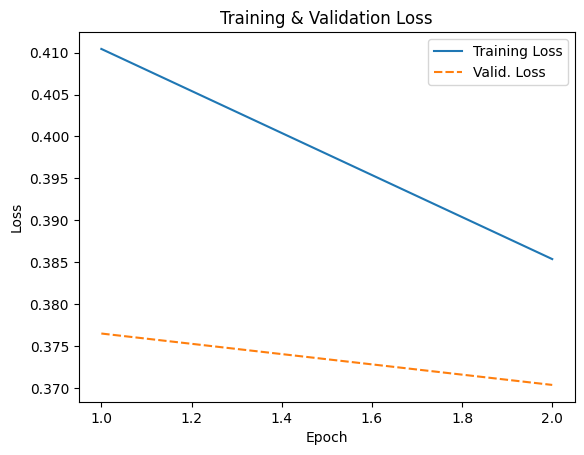

In [38]:
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

sns.lineplot(data=df_stats[['Training Loss', 'Valid. Loss']])

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")

plt.show()

In [39]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [40]:
output_dir = '/kaggle/working/gpt2-fa-formalize-lora'
os.makedirs(output_dir, exist_ok=True)

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
configuration.save_pretrained(output_dir)

# !cp /kaggle/working/gpt2/tokenizer.json /kaggle/working/gpt2-fa-formalize/

cp: cannot stat '/kaggle/working/gpt2/tokenizer.json': No such file or directory


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [41]:
from transformers import TFAutoModelForCausalLM
tf_model = TFAutoModelForCausalLM.from_pretrained("/kaggle/working/gpt2-fa-formalize-lora/", from_pt=True)
print(tf_model.summary())
tf_model.save_pretrained("/kaggle/working/gpt2-fa-formalize-tf")


!cp /kaggle/working/gpt2-fa-formalize-tf/tf_model.h5 /kaggle/working/gpt2-fa-formalize
!rm -rf /kaggle/working/gpt2-fa-formalize-tf

I0000 00:00:1755075534.872440      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11628 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755075534.873308      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13824 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2LMHeadModel: ['transformer.h.6.attn.masked_bias', 'transformer.h.7.attn.masked_bias', 'transformer.h.9.attn.masked_bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.3.attn.masked_bias', 'transformer.h.5.attn.masked_bias', 

Model: "tfgpt2lm_head_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLay  multiple                  118099200 
 er)                                                             
                                                                 
Total params: 118099200 (450.51 MB)
Trainable params: 118099200 (450.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [42]:
def generator(informal, max_length=128, num_return_sequences=3):
    model.eval()
    prompt = f"<s><|startoftext|>[Informal]{normalize_text(informal)}[Formal]"

    generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
    generated = generated.to(device)

    decoded_outputs = model.generate(
        generated,
        do_sample=True,
        top_k=50,
        max_length=max_length,
        top_p=0.95,
        num_return_sequences=num_return_sequences
    )

    outputs = []
    for i, output in enumerate(decoded_outputs):
        o = tokenizer.decode(output, skip_special_tokens=False)
        o = o.replace("<s>", "").replace("</s>", "").replace("<|startoftext|>", "").replace("<|endoftext|>", "").replace("<pad>", "")
        pattern = r'\[Informal\].*?\[Formal\]'
        o = re.sub(pattern, '', o)
        outputs.append(o)

    if num_return_sequences > 1:
        print('Input: ', informal, "\n")
        print('Prompt: ', prompt, "\n")
        print('Outputs: ')

        for out in outputs:
            print(out)

    return outputs

In [43]:
out = generator("امروز روز خوبیه")


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.


Input:  امروز روز خوبیه 

Prompt:  <s><|startoftext|>[Informal]امروز روز خوبیه[Formal] 

Outputs: 
امروز روز خوبی است.
امروز روز خوبی است.
امروز روز خوبی است.


In [44]:
out = generator("اخه چه فایده داره این کار!!!")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.


Input:  اخه چه فایده داره این کار!!! 

Prompt:  <s><|startoftext|>[Informal]اخه چه فایده داره این کار!!![Formal] 

Outputs: 
خیلی فایده دارد این کار؟
آخر این چه فایده دارد این کار؟!
آخر چه فایده‌ای دارد این کار؟!


In [45]:
out = generator("بنظرت کارما میگیرتش؟!")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.


Input:  بنظرت کارما میگیرتش؟! 

Prompt:  <s><|startoftext|>[Informal]بنظرت کارما میگیرتش؟![Formal] 

Outputs: 
بنظرت کارما می‌گیری؟!
بنظرت کارما را می‌گیردی؟!
بنظرت کارما می‌گیرند؟!


In [48]:
out = generator("واقعا خیلی حیف شد... حقمون نبود اینقدر ظلم بشه.. من خدایی میترسم")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.


Input:  واقعا خیلی حیف شد... حقمون نبود اینقدر ظلم بشه.. من خدایی میترسم 

Prompt:  <s><|startoftext|>[Informal]واقعا خیلی حیف شد... حقمون نبود اینقدر ظلم بشه.. من خدایی میترسم[Formal] 

Outputs: 
واقعاً خیلی حیف شد، همین‌قدر حقمان نشد، همین‌قدر ظلم بشود.
واقعاً خیلی حیف شد، حقمان نبود، قدر هم اصلاً خدا نمی‌بینم.
واقعاً خیلی حیف شد؛ این‌قدر ما خدایی نمی‌ترسم. من خدایی می‌ترسم؟


In [49]:
import dadmatools.pipeline.language as language

nlp = language.Pipeline("tok")

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

persian.vocabs.json: 0.00B [00:00, ?B/s]

persian_lemmatizer.pt:   0%|          | 0.00/2.89M [00:00<?, ?B/s]

persian_mwt_expander.pt:   0%|          | 0.00/589k [00:00<?, ?B/s]

persian.tagger.mdl:   0%|          | 0.00/17.0M [00:00<?, ?B/s]

persian.tokenizer.mdl:   0%|          | 0.00/9.51M [00:00<?, ?B/s]

Loading pretrained XLM-Roberta, this may take a while...


Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

OSError: Can't load weights for 'xlm-roberta-base'. Make sure that:

- 'xlm-roberta-base' is a correct model identifier listed on 'https://huggingface.co/models'

- or 'xlm-roberta-base' is the correct path to a directory containing a file named one of pytorch_model.bin, tf_model.h5, model.ckpt.



In [50]:
!pip install hazm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.6/892.6 kB 11.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 62.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 86.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.7 MB/s eta 0:00:00
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9300 sha256=dac52bfd62746d26c27af2747b01efad856719fdd9522f1c1211e0287c16f265
  Stored in directory: /root/.cache/pip/wheels/49/20/47/f03dfa8a7239c54cbc44ff7389eefbf888d2c1873edaaec888
Successfully built flashtext
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.


In [ ]:
normalizer = Normalizer()
i = 341

reference_text = df_parsmap['formalForm'][i]

generated_text = generator(df_parsmap['inFormalForm'][i], num_return_sequences=1)[0]

reference_tokens = word_tokenize(reference_text)
generated_tokens = word_tokenize(generated_text)

bleu_score = sentence_bleu([reference_tokens], generated_tokens)

print("BLEU score:", bleu_score)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.


BLEU score: 1.133422688662942e-154


In [ ]:

sample_size = 1000

sample_indices = random.sample(range(len(df_parsmap)), sample_size)
reference_texts = [df_parsmap.iloc[i]['formalForm'] for i in sample_indices]
generated_texts = [generator(df_parsmap.iloc[i]['inFormalForm'], num_return_sequences=1)[0] for i in sample_indices]

reference_tokens = [word_tokenize(text) for text in reference_texts]
generated_tokens = [word_tokenize(text) for text in generated_texts]

bleu_scores = []
smoothing_func = SmoothingFunction()
for ref_tokens, gen_tokens in zip(reference_tokens, generated_tokens):
    bleu_score = sentence_bleu([ref_tokens], gen_tokens, smoothing_function=smoothing_func.method1)
    bleu_scores.append(bleu_score)

avg_bleu_score = sum(bleu_scores) / len(bleu_scores)

print("Average BLEU score on random sample of size", sample_size, ":", avg_bleu_score)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:5 for open-end generation.
The attentio

Average BLEU score on random sample of size 1000 : 0.3457252647901324


In [ ]:
login(token="<YOUR-HF-TOKEN>")

repo_id = "AylinNaebzadeh/gpt2-fa-formalize-lora"
model.push_to_hub(repo_id)      # uploads adapters
tokenizer.push_to_hub(repo_id)  # uploads tokenizer